# 07. Molecules CG Mapping 

In this tutorial, we show how to generate a CG mapping matrix for a molecule given a bead mapping. The trajectory and topology file come from a AA simulation done in gromacs (see `Molecules_CG_Mapping` folder). The protein is FF (diphenylalanine) and the solvent is a mixture of water and methanol.

In [1]:
# disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import hoomd, hoomd.htf as htf, hoomd.md
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import MDAnalysis as mda
from os import path
import matplotlib.pyplot as plt,matplotlib

In [2]:
# Loading inputs
TPR = 'Molecules_CG_Mapping/nvt_prod.tpr'
tpr = mda.Universe(TPR)
TRAJECTORY = 'Molecules_CG_Mapping/traj.trr'
u = mda.Universe(TPR, TRAJECTORY)

# Generating Mapping Matrix for FF
protein_FF = u.select_atoms("resname PHE and resid 0:1")
beads_mapping_FF = [['N','H1','H2','H3'],
                     ['CA','HA','CB','HB1','HB2'],
                     ['CG','CD1','HD1','CD2','HD2','CE1','HE1','CE2','HE2','CZ','HZ'],
                     ['C','O'],
                     ['N','H'],
                     ['CA','HA','CB','HB1','HB2'],
                     ['CG','CD1','HD1','CD2','HD2','CE1','HE1','CE2','HE2','CZ','HZ'],
                     ['C','O1','O2']]
mapping_FF = htf.matrix_mapping(protein_FF,beads_mapping_FF)
print (mapping_FF)

/home/mgholiza/.conda/envs/hoomd-tf2/lib/python3.7/site-packages/MDAnalysis/core/universe.py:171: UserWarning: No coordinate reader found for Molecules_CG_Mapping/nvt_prod.tpr. Skipping this file.
  'this file.'.format(filename))


[[0.8224383  0.05918723 0.05918723 0.05918723 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.44409524 0.03726984
  0.44409524 0.03726984 0.03726984 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.15577257 0.15577257 0.01307

Since the bonded ineractions were removed from the GROMACS traj, we need to consider and exclusion list to only account for non-bonded interactions between the beads.

In [3]:
mapped_exclusion_list = htf.gen_mapped_exclusion_list(u, protein_FF, beads_mapping_FF, selection="resname PHE")
print(mapped_exclusion_list[0][0:8])
print(mapped_exclusion_list[5][0:8])


[False  True False False False False False False]
[False False False False  True False  True  True]


This means that bead `1` is bonded with bead  `2` and bead `6` is bonded with beads `5`, `7`, `8`. 

Let's look at the number of bead types:

In [4]:
def bead_type_finder(beads_mapping):
    # beads_mapping input is a list of lists of mappings in a molecule
    unique_beads = []
    bead_types = []
    for m in beads_mapping:
        if m not in unique_beads:
            unique_beads.append(m)
        bead_types.append(unique_beads.index(m))
        n_beads = len(unique_beads)
        # bead_types is an array for the type of the beads in the molecule
        # n_types is the total number of unique beads in the molecule
    return n_beads, np.array(bead_types, dtype=np.float32)[np.newaxis,...]
n_bead_types, bead_types = bead_type_finder(beads_mapping_FF)
print (n_bead_types, bead_types)

6 [[0. 1. 2. 3. 4. 1. 2. 5.]]


The molecular-level mapping operator can be generated for the solvents too, but we don't really need them.

In [5]:
# Generating Mapping Matrix for Water
water = u.select_atoms("resname SOL and resid 500")
bead_mapping_water = [['OW','HW1','HW2']]
mapping_water = htf.matrix_mapping(water,bead_mapping_water)             
print (mapping_water)

[[0.88809574 0.05595213 0.05595213]]


In [6]:
# Generating Mapping Matrix for Methanol
methanol = u.select_atoms("resname MET and resid 11665 ")
beads_mapping_methanol = [['C','H','H','H','OA','HO']]
mapping_methanol = htf.matrix_mapping(methanol,beads_mapping_methanol)             
print (mapping_methanol)

[[0.37484707 0.03145832 0.03145832 0.03145832 0.49931966 0.03145832]]


In [7]:
# Getting the segment id of each molecule in topology
_,idx = np.unique(u.select_atoms('all').segids,return_index=True)
seg_id_list = u.select_atoms('all').segids[np.sort(idx)].tolist()

# Getting the list of every molecule type name in topology
_,idx = np.unique(u.atoms.resnames,return_index=True)
resname_list = u.atoms.resnames[np.sort(idx)].tolist()

# Getting list of atoms in each type of molecule
atoms_in_molecule_list = [protein_FF.names,
                          water.names,
                          methanol.names]

In [8]:
atoms_in_molecule_list = [protein_FF.names]
molecule_mapping_index = htf.find_molecules_from_topology(u,atoms_in_molecule_list, selection = "resname PHE")
molecule_mapping = mapping_FF

# get number of atoms
N = sum([len(m) for m in molecule_mapping_index])
# get number of molecules
M = len(molecule_mapping_index)
# get number of beads
B = molecule_mapping.shape[0]

#create a mass-weighted (M * bead_number) x N mapping operator 
cg_mapping = htf.sparse_mapping([molecule_mapping for _ in molecule_mapping_index], 
                                molecule_mapping_index)
assert cg_mapping.shape == (M * B, N)
print (M*B)

160


## Training a Keras Layer

In [9]:
l1 = 0.1
lr = 1e-3

In [10]:
class PotentialLayer(tf.keras.layers.Layer):
    def __init__(self, N_hidden, CG_NN, rcut, n_total_bead_type_interactions):
        super(PotentialLayer, self).__init__(self, name='pf')
        w_avg = (rcut / N_hidden / 2) ** 2 
        self.rcut = rcut
        self.N_hidden = N_hidden
        self.CG_NN = CG_NN
        self.n_total_bead_type_interactions = n_total_bead_type_interactions
    def build(self,input_shape):
        self.widths = self.add_weight(
                shape = (self.N_hidden,), initializer = tf.constant_initializer(value=0.1),
                trainable = False, name='widths')
        self.heights = self.add_weight(
                shape = (self.n_total_bead_type_interactions, self.N_hidden),
                        initializer = tf.random_uniform_initializer(maxval=0.001, minval=-0.001),
                        regularizer=tf.keras.regularizers.l1(l1=l1),
                        trainable = True, name='heights')
        self.lj_loc = self.add_weight(
                shape = (self.CG_NN,), initializer = "ones",
                regularizer=tf.keras.regularizers.l2(),
                trainable = True, name='lj_loc')
    def call(self, m_r, interactions):
        flat_r = tf.tile(tf.reshape(m_r, [-1, 1]), [1, self.N_hidden])
        offsets = tf.linspace(2.5, self.rcut, self.N_hidden, name='offsets')[tf.newaxis,...]
        w_avg = (self.rcut / self.N_hidden / 2) ** 2    
        activation = tf.math.exp(-(flat_r - offsets) ** 2 / self.widths)
        activation = tf.reshape(activation, [-1,self.CG_NN, self.N_hidden])
        activation_g = activation[:, :, tf.newaxis,:] * self.heights
        interactions = tf.reshape(interactions,[-1, self.CG_NN, 1, self.n_total_bead_type_interactions])
        output_layer = tf.reduce_sum(interactions @ activation_g, axis=3)
        nn_energies = tf.reshape(output_layer, shape=[-1, self.CG_NN]) # + lj_force
        mask = tf.reshape(tf.cast((m_r > 1e-1), tf.float32), [-1, self.CG_NN])
        neighs = tf.reduce_mean(tf.reduce_sum(mask, axis=1), axis=0)
        predicted_CG_energy = tf.reduce_sum(nn_energies * mask, axis=1, name='predicted_energies')
        return predicted_CG_energy
    def get_config(self):
        config = super(PotentialLayer, self).get_config()
        config.update({
                'widths': self.widths.numpy(),
                'heights': self.widths.numpy(),
                'lj_loc': self.lj_loc.numpy(),
                'rcut': self.rcut,
                'N_hidden': self.N_hidden,
                'CG_NN': self.CG_NN,
                'n_total_bead_type_interactions': self.n_total_bead_type_interactions})
        return config
class TrainablePF(htf.SimModel):
    def setup(self, cg_mapping, rcut, CG_NN, N_hidden, n_bead_types):
        self.rcut = rcut
        self.cg_mapping = cg_mapping
        self.CG_NN = CG_NN
        self.N_hidden = N_hidden
        I = n_bead_types*(n_bead_types-1)//2 + n_bead_types
        self.pf = PotentialLayer(N_hidden, CG_NN, rcut, I)
        self.wca = htf.WCARepulsion(1e-3)
        self.avg_mapped_rdf = tf.keras.metrics.MeanTensor('avg-mapped-rdf') 
        self.n_bead_types = n_bead_types

    def compute(self, mapped_nlist, mapped_pos_with_type):
        m_r = htf.safe_norm(tensor=mapped_nlist[:, :, :3], axis=2)
        nlist_btype = tf.cast(mapped_nlist[..., -1], dtype = tf.int32)
        pos_btype = tf.cast(mapped_pos_with_type[...,-1], dtype = tf.int32)
        interactions = htf.compute_ohe_bead_type_interactions(pos_btype,nlist_btype, self.n_bead_types)
        predicted_m_energy = self.pf(m_r, interactions) + tf.reduce_sum(self.wca(mapped_nlist), axis=1) #adding repulsion from WCA
        predicted_m_forces = htf.compute_nlist_forces(mapped_nlist, predicted_m_energy)
        predicted_m_rdf = []
        for i in range(self.n_bead_types):
            for j in range(self.n_bead_types):
                p_index_m_rdf = htf.compute_rdf(mapped_nlist, [0.01, self.rcut],
                                              type_tensor = mapped_pos_with_type[:,3], type_i=i, type_j=j)
                predicted_m_rdf.append(p_index_m_rdf)
        self.avg_mapped_rdf.update_state(predicted_m_rdf)
        return  predicted_m_forces[:,:3], predicted_m_energy

In [11]:
# defining bead types
n_bead_types = 6
system_bead_types = tf.repeat(bead_types, M, axis=0)
r_cut = 25
CG_NN = 64
N_hidden =48
model = TrainablePF(64, cg_mapping = cg_mapping, rcut = r_cut, CG_NN = CG_NN, N_hidden = N_hidden,
                   n_bead_types=n_bead_types)
from tensorflow import keras
optimizer=keras.optimizers.Adam(lr=lr, clipnorm=1.0) 
model.compile(optimizer=optimizer, loss=['MeanSquaredError', None])
N_CG_particles = M*B
losses_train = []
L_Train = []

Here we redefine the TRAJECTORY (forces included) and TPR so that they only contain protein atoms. This was done using `trjconv` command in GROMACS. The training was done for `20` epochs on a 90 ns trajectory. The code is available here but results are just loaded from the `Molecules_CG_Mapping` folder.

In [12]:
run_training = False
epochs = 20
if run_training:
    for i in range(epochs):
        for inputs, ts in htf.iter_from_trajectory(512, u, selection='resname PHE', r_cut=r_cut, period =1):
            aa_forces = ts.forces
            true_mapped_force = tf.sparse.sparse_dense_matmul(cg_mapping, aa_forces, name='true-mapped-forces')
            nlist = inputs[0]
            positions = inputs[1]
            box_size = tf.cast(htf.box_size(inputs[2]), tf.float32)
            # calculate the center of mass of a CG bead
            mapped_pos = htf.center_of_mass(positions[:,:3], cg_mapping, box_size)
            system_bead_types = tf.reshape(system_bead_types,[-1,1])
            mapped_pos_with_type = tf.concat([mapped_pos, system_bead_types], axis =1)
            # Getting mapped_nlist based on non-bonded bead type interactions
            mapped_nlist = htf.compute_nlist(mapped_pos_with_type, r_cut, CG_NN, box_size, sorted=False,
                                             return_types=True, exclusion_matrix=mapped_exclusion_list)
            predicted_mapped_forces, predicted_energy = model([mapped_nlist, mapped_pos_with_type])
            model_inputs = [mapped_nlist, mapped_pos_with_type, box_size] + inputs[3:]
            labels = true_mapped_force
            loss_train = model.train_on_batch(model_inputs, labels, reset_metrics=False)
            losses_train.append(loss_train)
        loss_values_train = np.mean(np.array(losses_train)[:,0]) # get the mean for time-step

        L_Train.append(loss_values_train/3/N_CG_particles)
        print(f'epoch: {i+1}', f' Train Loss = {loss_values_train/3/N_CG_particles}')
        model.save_weights(f'Molecules_CG_Mapping/weights/weights_epoch_{i+1}_lr_{lr}_l1_{l1}')
    dat = {'L_Train':L_Train, 'mapped_possition_t0':mapped_possition_t0.numpy(),
            'mapped_nlist_t0':mapped_nlist_t0.numpy(), 'box_size':box_size.numpy()}
    with open(f'Molecules_CG_Mapping/training_lr_{lr}_l1_{l1}.npz', 'wb') as f:
        np.savez(f,**dat)

In [13]:
# model.save(f'Molecules_CG_Mapping/model_lr_{lr}_l1_{l1}', overwrite=True)

In [18]:
dat = np.load(f'Molecules_CG_Mapping/training_lr_{lr}_l1_{l1}.npz')
L_Train = dat['L_Train']
mapped_possition_t0 = dat['mapped_possition_t0']
mapped_nlist_t0 = dat['mapped_nlist_t0']
box_size = dat['box_size']

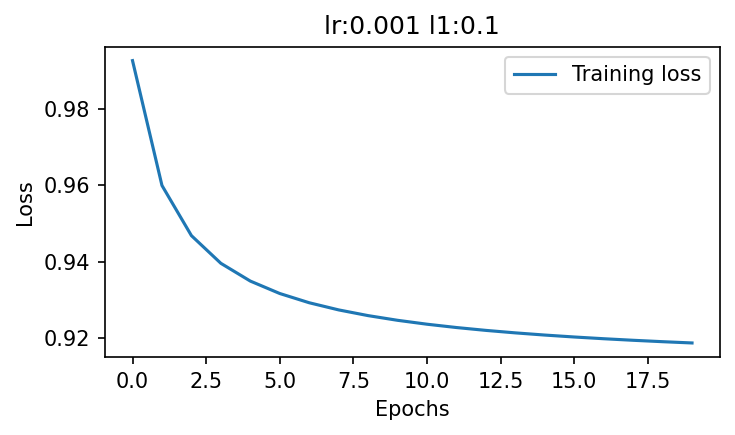

In [19]:
plt.figure(figsize=(5,3), dpi = 150)
plt.plot(range(epochs), L_Train, label='Training loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title(f'lr:{lr} l1:{l1}')
plt.tight_layout()
# plt.savefig(f'Loss_mixed_lr_{lr}_l1_{l1}.png', dpi=300)

Let's load the weights into a new model:

In [20]:
new_model = TrainablePF(64, cg_mapping = cg_mapping, rcut = r_cut, CG_NN = CG_NN, N_hidden = N_hidden,
                   n_bead_types=n_bead_types)
new_model.load_weights(f'Molecules_CG_Mapping/weights/weights_epoch_{epochs}_lr_{lr}_l1_{l1}')

Calculating mapped potentials per bead type interaction:

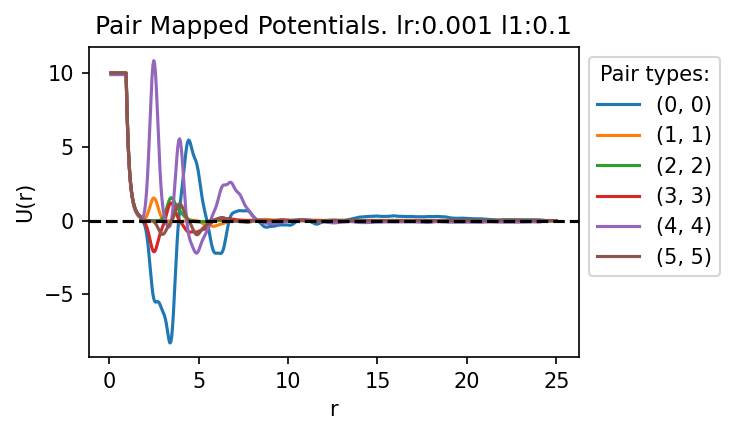

In [21]:
r = np.linspace(0.1, r_cut, 500)
p_list = []
plt.figure(figsize=(5,3), dpi = 150)
for i in range(n_bead_types):
    output_forces, potential_energy = htf.compute_pairwise(new_model, r, type_i=i, type_j=i)
    plt.plot(r, potential_energy[:,0] - potential_energy[-1,0], label=f'{i,i}', color=f'C{i}')
    p_list.append(potential_energy)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel(r'r')
plt.ylabel(r'U(r)')
plt.legend(bbox_to_anchor=(1, 1),title='Pair types:')
plt.title(f'Pair Mapped Potentials. lr:{lr} l1:{l1}')
plt.tight_layout()
# plt.savefig(f'Mapped_Potential_mixed_lr_{lr}_l1_{l1}.png', dpi=300)

Text(0.5, 1.0, 'Pair Mapped Potentials')

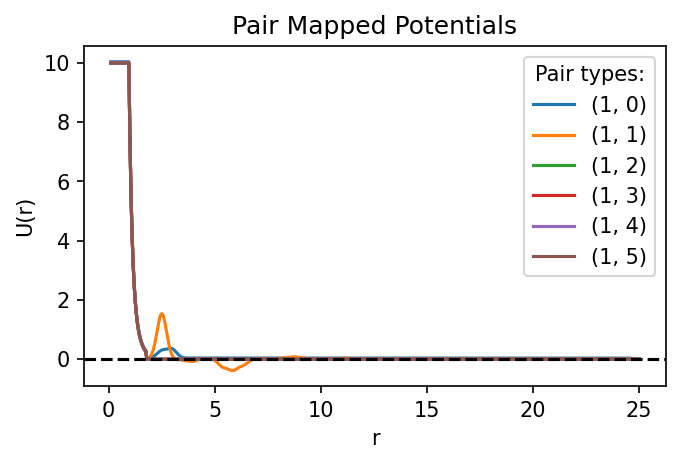

In [24]:
plt.figure(figsize=(5,3), dpi = 150)
for i in range(n_bead_types):
    output_forces, potential_energy = htf.compute_pairwise(new_model, r, type_i=1, type_j=i)
    plt.plot(r, potential_energy[:,0] - potential_energy[-1,0], label=f'{1,i}', color=f'C{i}')
    p_list.append(potential_energy)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel(r'r')
plt.ylabel(r'U(r)')
plt.legend(bbox_to_anchor=(1, 1),title='Pair types:')
plt.title('Pair Mapped Potentials')

Text(0.5, 1.0, 'Pair Mapped Potentials')

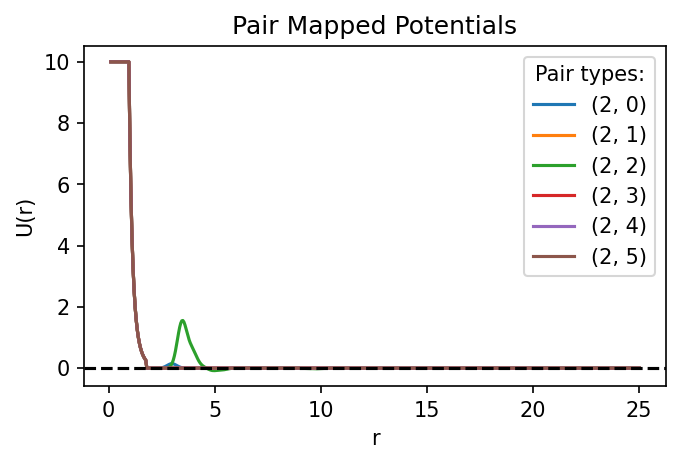

In [27]:
plt.figure(figsize=(5,3), dpi = 150)
for i in range(n_bead_types):
    output_forces, potential_energy = htf.compute_pairwise(new_model, r, type_i=2, type_j=i)
    plt.plot(r, potential_energy[:,0] - potential_energy[-1,0], label=f'{2,i}', color=f'C{i}')
    p_list.append(potential_energy)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel(r'r')
plt.ylabel(r'U(r)')
plt.legend(bbox_to_anchor=(1, 1),title='Pair types:')
plt.title('Pair Mapped Potentials')

Plotting mapped rdfs:

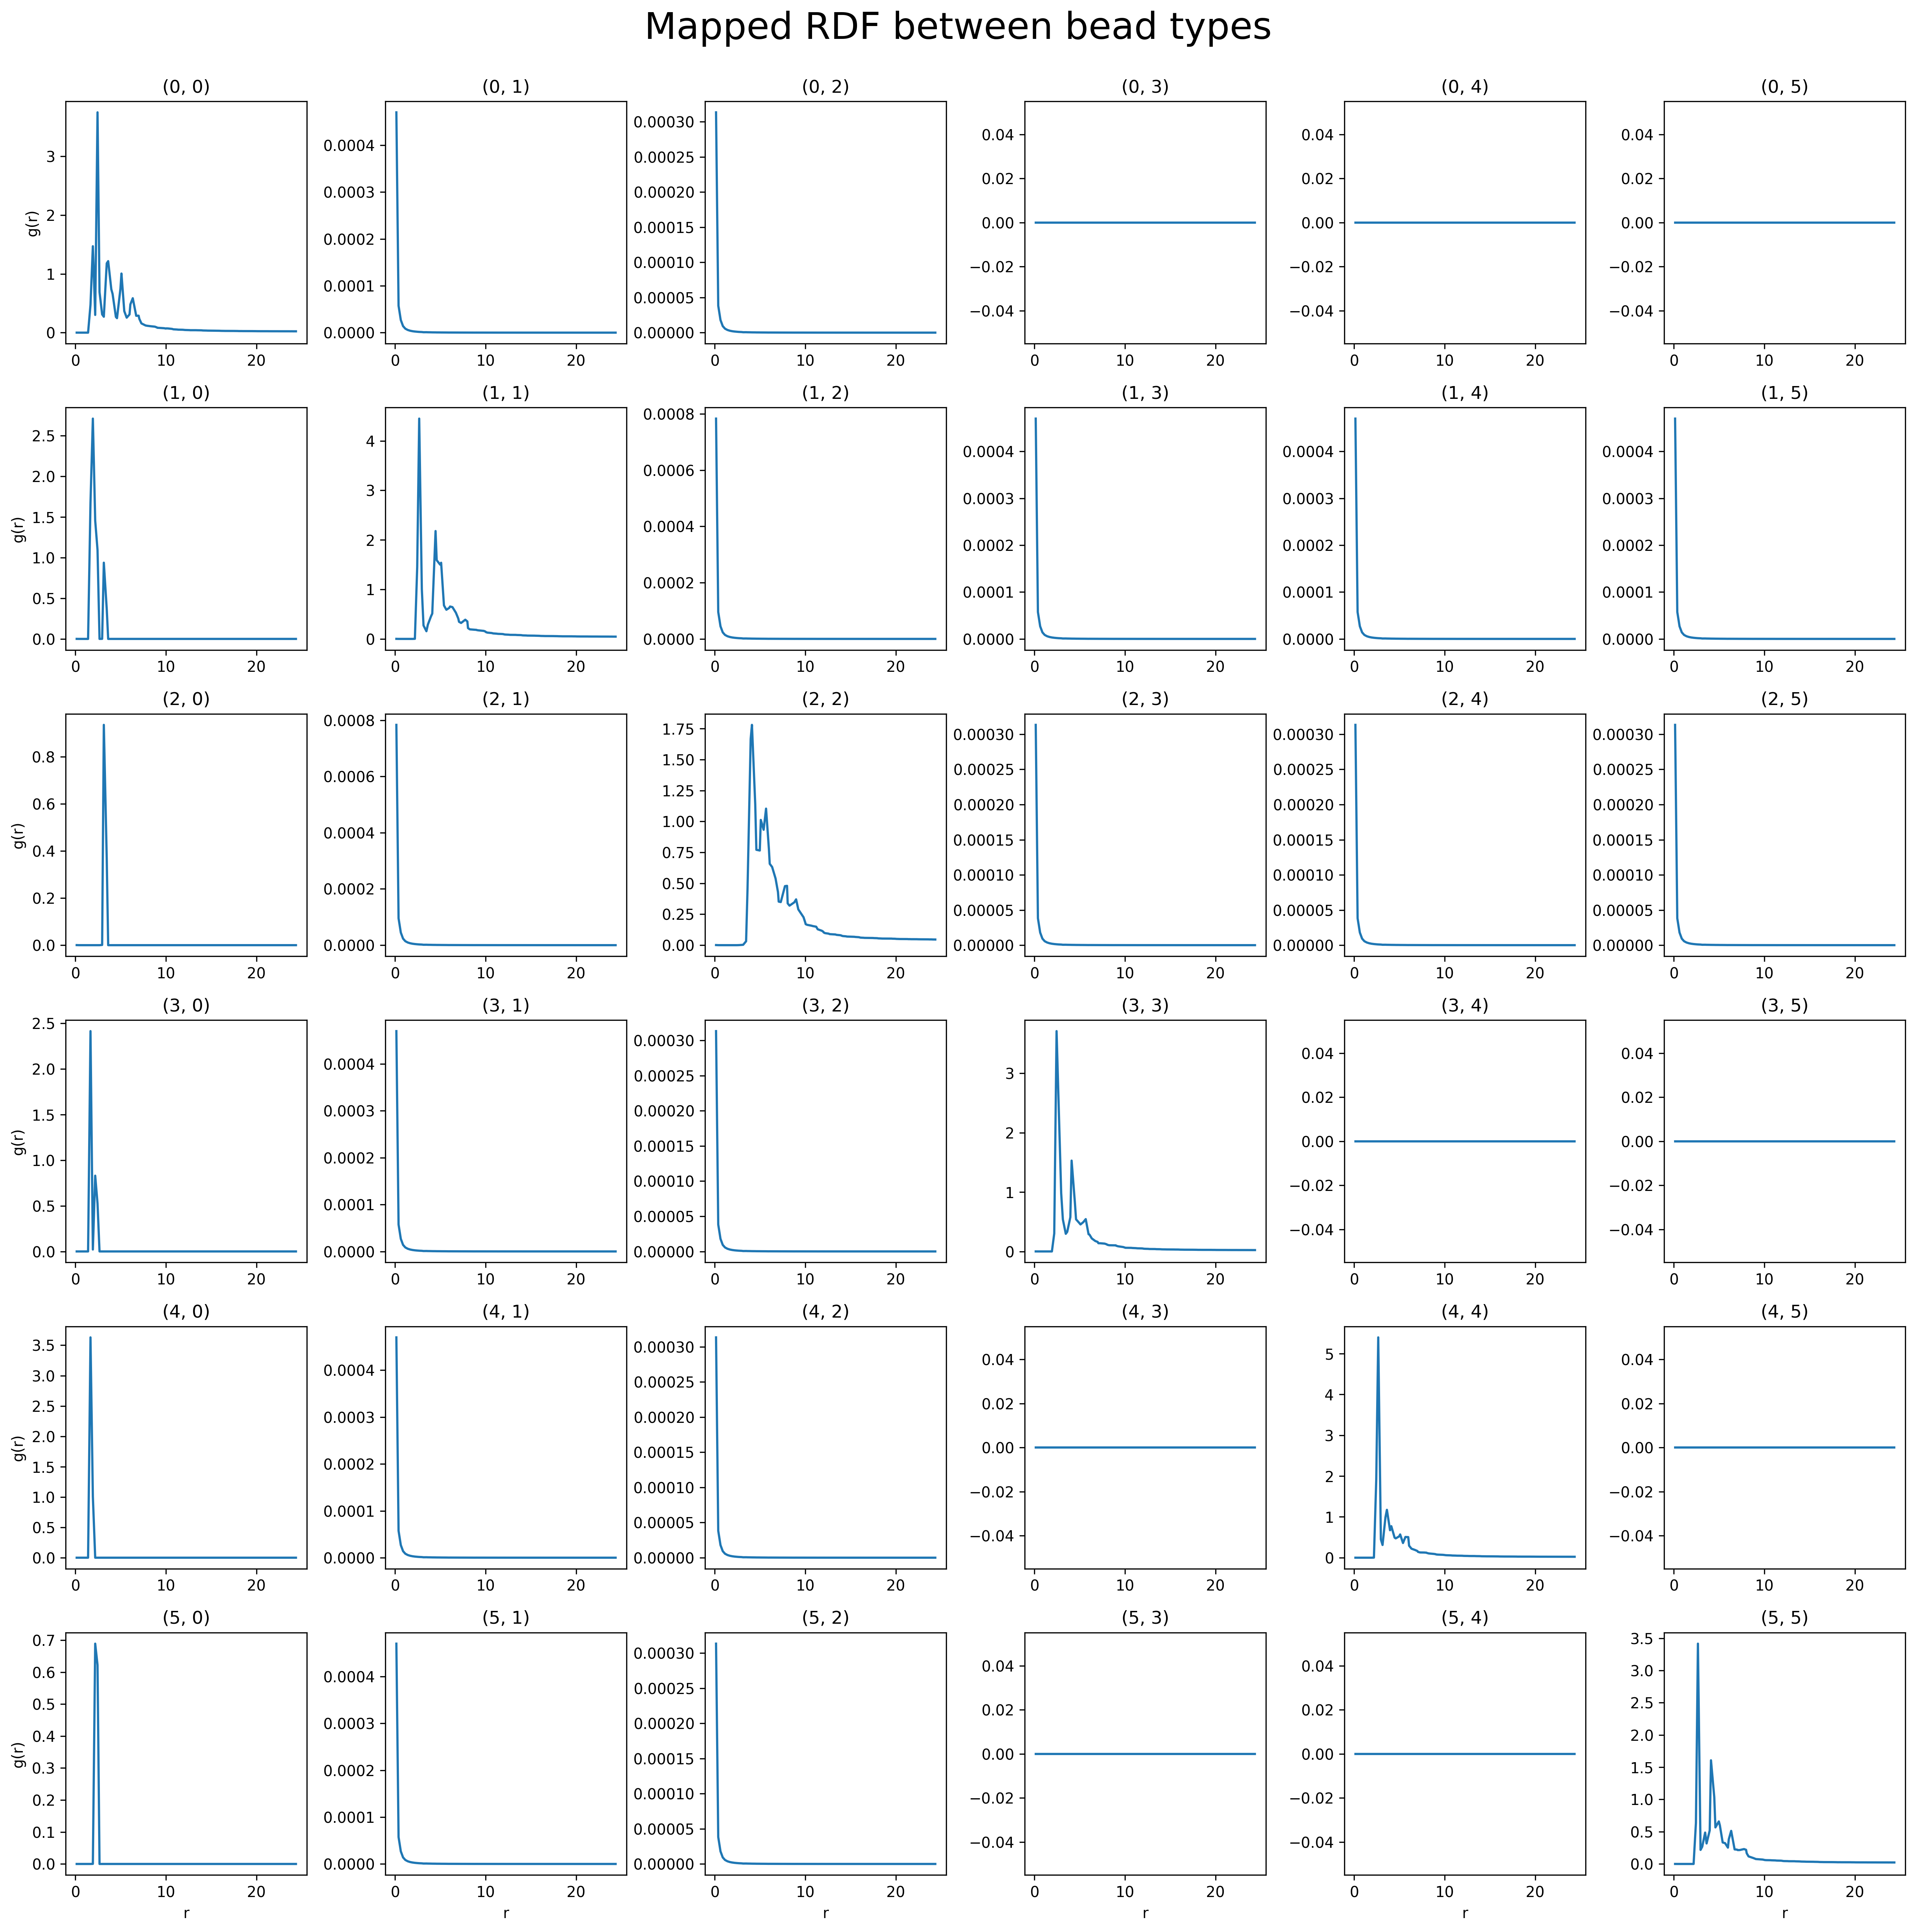

In [28]:
mapped_RDF = new_model.avg_mapped_rdf.result().numpy().reshape([n_bead_types,n_bead_types,2,-1])
fig, axs = plt.subplots(nrows=n_bead_types, ncols= n_bead_types, figsize=(18,18), dpi = 300)
for i in range(n_bead_types):
    for j in range(n_bead_types):
        axs[i,j].plot(mapped_RDF[i,j,1, :], mapped_RDF[i,j,0, :], label='Mapped RDF', color='C0')
        axs[i,j].set_title(f'{i,j}')
    axs[i,0].set_ylabel(r'g(r)')
    axs[-1,i].set_xlabel(r'r')
fig.suptitle('Mapped RDF between bead types', y=1.00, fontsize=25)
plt.tight_layout()